# Original Python Version

In [0]:
import numpy as np

In [0]:
def mandelbrot(centre, view_side, n_max_iter = 500, view_side_pixels = 500):
  # The output is a square image, view_side is the size of the side of this
  # image in the complex plane. The view_side_pixels is the number of pixels
  # this correspond to.
  step = view_side/view_side_pixels
  # Store the pixels as a list of lists
  image = list()
  for i in range(view_side_pixels):
    image.append([])
    for j in range(view_side_pixels):
      # Find c for this pixel
      c = centre + view_side*complex(-.5, .5) + complex(j*step, -i*step)
      # Initial z
      z = complex(0, 0)
      # Iterate to generate the series
      n = 0
      # Loop until a maximum number of allowed iterations or until the 
      # series diverges.
      while n < n_max_iter and abs(z) < 2: 
        # The update
        z = z*z + c
        # Increase the iteration counter
        n += 1
      # If the series did diverge, store the number of iterations it took (our
      # colouring will be proportional to this). If not, store a zero.
      if n == n_max_iter:
        image[i].append(0)
      else:
        image[i].append(n)
  # Transform the list of lists into a numpy matrix
  return np.asarray(image)

# Cython Version

In [117]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [118]:
%%cython -a
import numpy as np
cimport cython
cimport numpy as np

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def mandelbrot_cy(complex centre, double view_side, int n_max_iter = 255, int view_side_pixels = 500):
  # The output is a square image, view_side is the size of the side of this
  # image in the complex plane. The view_side_pixels is the number of pixels
  # this correspond to.
  cdef double step = view_side / view_side_pixels
  cdef int i, j, n
  # Store the pixels as a list of lists
  cdef np.ndarray image = np.zeros((view_side_pixels, view_side_pixels), dtype=np.intc)
  cdef double creal = centre.real
  cdef double cimag = centre.imag
  cdef double c1, c2, z1, z2, tmp
  #image = list()
  for i in range(view_side_pixels):
    #image.append([])
    for j in range(view_side_pixels):
      # Find c for this pixel
      #c = centre + view_side*complex(-.5, .5) + complex(j*step, -i*step)
      c1 = creal + view_side * (-0.5) + j * step
      c2 = cimag + view_side * 0.5 - i * step
      # Initial z
      #z = complex(0, 0)
      z1 = 0
      z2 = 0
      # Iterate to generate the series
      n = 0
      # Loop until a maximum number of allowed iterations or until the 
      # series diverges.
      while n < n_max_iter and z1 < 2 and z2 < 2 and z1 > -2 and z2 > -2: 
        # The update
        #z = z*z + c
        tmp = z1
        z1 = z1 * z1 - z2 * z2 + c1
        z2 = 2 * tmp * z2 + c2
        # Increase the iteration counter
        n += 1
      # If the series did diverge, store the number of iterations it took (our
      # colouring will be proportional to this). If not, store a zero.
      if n < n_max_iter:
        #image[i].append(n)
        image[i,j] = n
  # Transform the list of lists into a numpy matrix
  #return np.asarray(image)
  return image

# Comparasion

In [119]:
%timeit mandelbrot(complex(-.74303, .126433), .01611, view_side_pixels = 200)
%timeit mandelbrot_cy(complex(-.74303, .126433), .01611, view_side_pixels = 200)

1 loop, best of 3: 1.86 s per loop
10 loops, best of 3: 31.4 ms per loop


# Testing

In [0]:
import numpy as np
import cv2 # open computer vision library, for video and image processing
import matplotlib.pyplot as plt

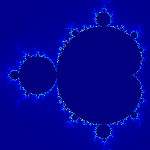

In [83]:
# Make the image
image = mandelbrot_cy(complex(-.5, 0), 2, view_side_pixels = 300)
# image = mandelbrot(complex(-.74303, .126433), .01611, view_side_pixels = 200)

# Apply colourmap
img = np.asarray(255*image/np.max(image), dtype=np.uint8)
img = cv2.applyColorMap(img, cv2.COLORMAP_JET)

# Optional resize (makes it look better at higher resolutions)
img = cv2.resize(img, (img.shape[0]//2, img.shape[1]//2), interpolation=cv2.INTER_CUBIC)

# Write the image and view it
cv2.imwrite('fractal.png', img)
from IPython.display import Image
Image('fractal.png')

# Video Generating

In [113]:
from tqdm import tqdm

frames = list()
for zoom in tqdm(np.exp(np.linspace(np.log(1), np.log(.00001), 500))):
  # Create the image for the given parameters
  image = mandelbrot_cy(complex(-0.743643887037158704752191506114774, 0.131825904205311970493132056385139), zoom, n_max_iter=255, view_side_pixels = 1000)
  
  # Apply colourmap
  img = np.asarray(255*image/np.max(image), dtype=np.uint8)
  img = cv2.applyColorMap(img, cv2.COLORMAP_JET)

  # Optional resize (makes it look better at higher resolutions)
  img = cv2.resize(img, (img.shape[0]//2, img.shape[1]//2), interpolation=cv2.INTER_CUBIC)

  # Store the frame
  frames.append(img)

100%|██████████| 500/500 [07:02<00:00,  1.22s/it]


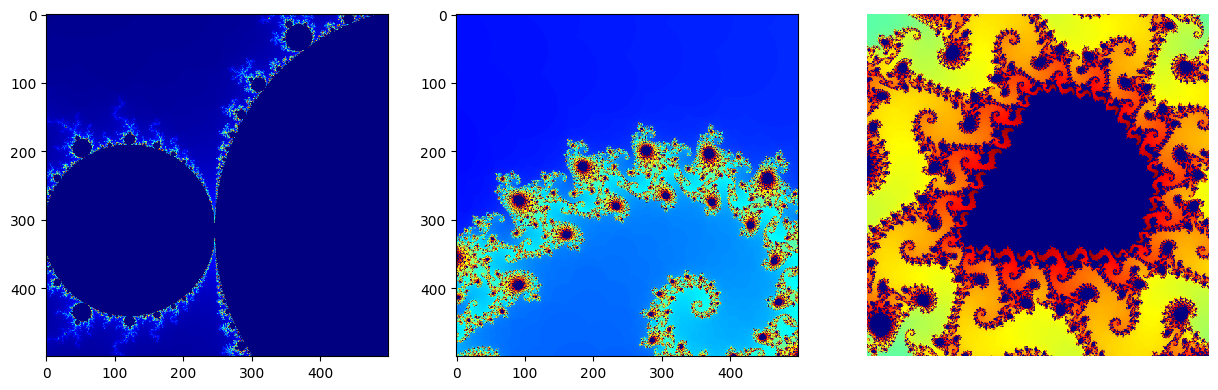

In [86]:
plt.figure(figsize=(15, 5), dpi=100)
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(frames[len(frames)//2], cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(frames[-1], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Multiprocessing

In [0]:
import time
start = time.time()
from multiprocessing import Pool

frames = list()
zooms = np.exp(np.linspace(np.log(1), np.log(.00001), 50))

def fun(zoom):
  # Create the image for the given parameters
  image = mandelbrot_cy(complex(-0.743643887037158704752191506114774, 0.131825904205311970493132056385139), zoom, n_max_iter=255, view_side_pixels = 1000)
  
  # Apply colourmap
  img = np.asarray(255*image/np.max(image), dtype=np.uint8)
  img = cv2.applyColorMap(img, cv2.COLORMAP_JET)

  # Optional resize (makes it look better at higher resolutions)
  img = cv2.resize(img, (img.shape[0]//2, img.shape[1]//2), interpolation=cv2.INTER_CUBIC)

  return img
  # Store the frame
with Pool(processes=8) as pool:
    frames = pool.map(fun, zooms)
end = time.time()

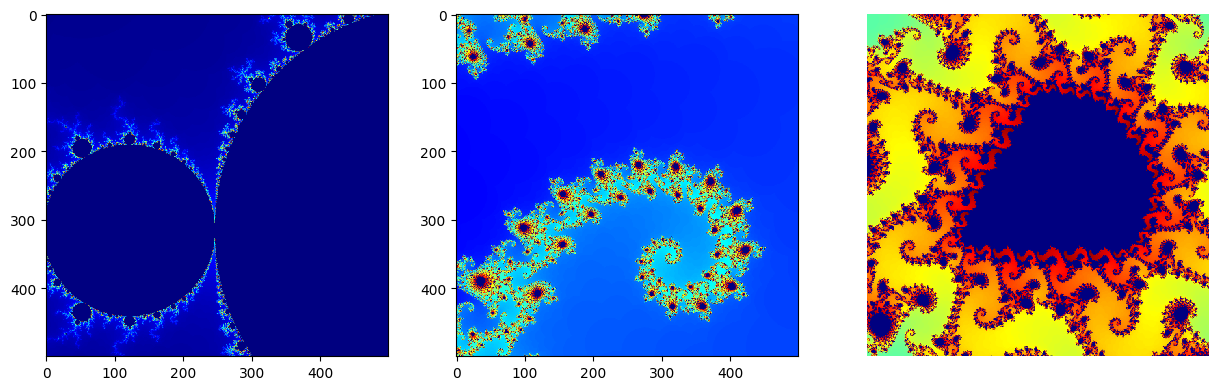

In [123]:
plt.figure(figsize=(15, 5), dpi=100)
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(frames[len(frames)//2], cv2.COLOR_BGR2RGB))
plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(frames[-1], cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [128]:
print(f"{(end - start)//60} mins {(end - start) % 60:.3f}s")

0.0 mins 29.956s
